### Wrap up findings on decomposing timeseries and setting up (Deep)ESN models

**Outline**

Up to now we have investigated some aspects on **pre-processing** timeseries with e.g. **scaling** and/or **de-composing**. We discussed statistical tests on evaluating **non-stationary** data.

We then implemented a custom class for an **ESN layer** and build functions to **set up ESN models**.

Time to step back and summarize our findings in this **wrap up**:

1. Stationary vs. non-stationary data, example: SP500 stock index data
2. Augmented Dickey-Fuller test (ADFT)
3. Additive decomposing of stock data
3. Decomposition of airline passenger data
4. Setting up (Deep)ESN models

#### Sources

* Apply **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks", we are soon ready to switch from base ESN to Deep ESN models.
* Work with **stock index** values (S&P 500) from [Yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/) and took **Airline Passengers** from [Tutorial](https://machinelearningmastery.com/time-series-data-stationary-python/) on "How to Check if Time Series Data is Stationary with Python".

#### Technical setup: Import libraries and customized own functions

In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v02 import *

In [2]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

In [17]:
# Read dataset airline-passengers.csv
AirPass = read_csv('../data/airline-passengers.csv', header=0, index_col=0).values[:,0]

### 1a. Stationary vs. non-stationary data 

Predicting stock prices is one of the most challenging problems in the context of timeseries prediction, since stock price movements are highly non-linear and non-stationary, at least when we look at absolute values.

Having **non-stationary** data means - in simple terms - that mean and variation change over time. Often by simply inspecting raw data we find some trend, that prohibits to have stationarity. Before modelling this kind of non-stationary data, one usually removes trend - e.g. by **de-composing** - and focusses on modelling the resudiual series. We will apply de-composing to airline passenger data. 

But before we do that we have a look at the S&P 500 stock market index in the timespan from August 14, 1999 to July 01, 2019, covering 5000 trading days. By inspecting raw data, we don't find a stable overall trend. We rather see a series of "local trends", called "bear markets" and "bull markets", characterized by a regime of declining and advanzing stock prices, respectively. We also observe *no* seasonality in stock price movements of any fixed cycle length.

People still try to overcome these difficulties and apply naive techniques to convert non-stationary series into stationary series: One often looks at **absolute differences** of **relative changes**, instead of absolute values.

In [4]:
# Convert SP500 data from absolute values to absolute differences and relative changes.
SP500_abs_diff = SP500_abs[1:] - SP500_abs[:-1]
SP500_rel_chg = (SP500_abs[1:] - SP500_abs[:-1]) / SP500_abs[:-1]

<function matplotlib.pyplot.show(close=None, block=None)>

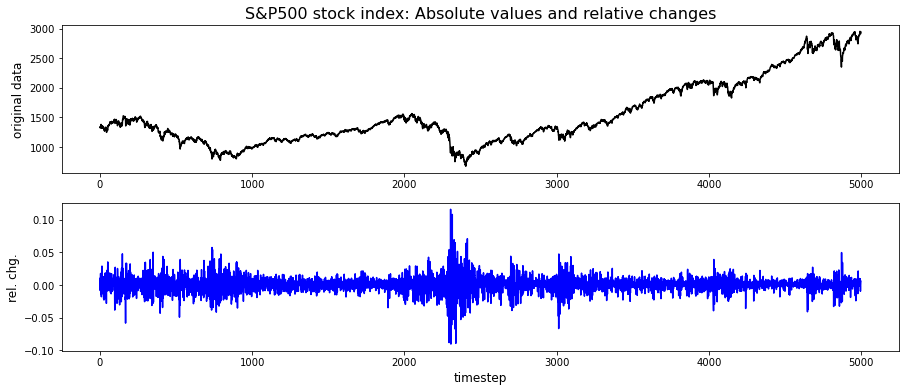

In [7]:
# Plot original stock index data in absolute values, compared to relative changes:
fig, axes = plt.subplots(2, 1, figsize=(15,6))
axes[0].plot(range(len(SP500_abs)), SP500_abs, color="k", label="original data")  
axes[1].plot(range(len(SP500_rel_chg)), SP500_rel_chg, color="b", label="rel. chg.")
#axes[0].set_xlabel("timestep", fontsize=12)
axes[1].set_xlabel("timestep", fontsize=12)
axes[0].set_ylabel("original data", fontsize=12)
axes[1].set_ylabel("rel. chg.", fontsize=12)
axes[0].set_title("S&P500 stock index: Absolute values and relative changes", fontsize=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

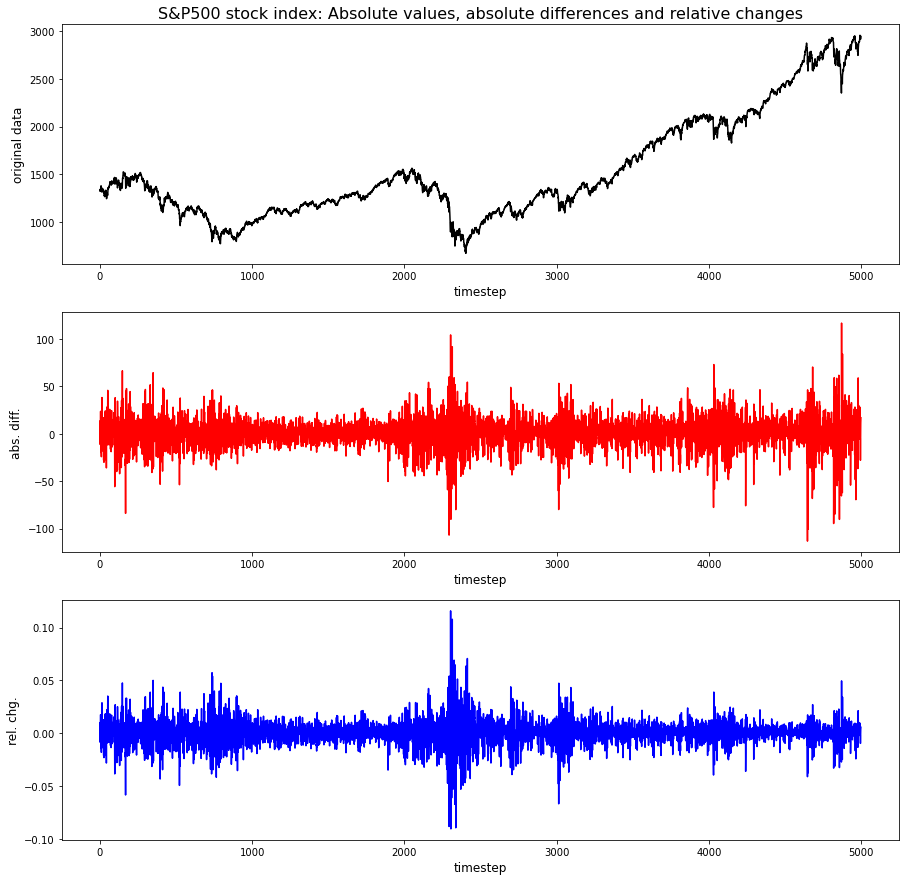

In [8]:
# Plot original stock index data in absolute values, compared to absolute differences and relative changes:
fig, axes = plt.subplots(3, 1, figsize=(15,15))
axes[0].plot(range(len(SP500_abs)), SP500_abs, color="k", label="original data")  
axes[1].plot(range(len(SP500_abs_diff)), SP500_abs_diff, color="r", label="abs. diff.")
axes[2].plot(range(len(SP500_rel_chg)), SP500_rel_chg, color="b", label="rel. chg.")
axes[0].set_xlabel("timestep", fontsize=12)
axes[1].set_xlabel("timestep", fontsize=12)
axes[2].set_xlabel("timestep", fontsize=12)
axes[0].set_ylabel("original data", fontsize=12)
axes[1].set_ylabel("abs. diff.", fontsize=12)
axes[2].set_ylabel("rel. chg.", fontsize=12)
axes[0].set_title("S&P500 stock index: Absolute values, absolute differences and relative changes", fontsize=16)
plt.show

### 1b. Summary statistics over time

Let's focus on relative change values of S&P500 timeseries. It can easily be proven that even converting absolute to relative change values does not overcome non-stationarity, when working with stock price data. Therefore we look at mean and standard deviation for two distinct periods in time:

- Period 1: Timesteps 1201 .. 1700 (green)
- Period 2: Timesteps 2001 .. 2500 (red)

<function matplotlib.pyplot.show(close=None, block=None)>

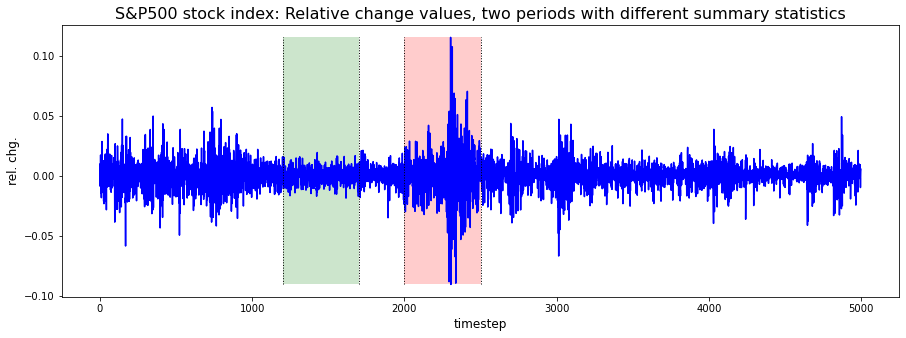

In [9]:
# Plot rel. change values for SP500 stock index, highlight two distinct periods with different summary statistics

# Get min/max for rel. changes, for plotting vertical barrier separating periods:
rel_chg_min = np.min(SP500_rel_chg)
rel_chg_max = np.max(SP500_rel_chg)

fig, axes = plt.subplots(1, 1, figsize=(15,5))
axes.plot(range(len(SP500_rel_chg)), SP500_rel_chg, color="b", label="rel. chg.")
axes.set_xlabel("timestep", fontsize=12)
axes.set_ylabel("rel. chg.", fontsize=12)
axes.set_title("S&P500 stock index: Relative change values, two periods with different summary statistics", fontsize=16)

# Include vertical barriers separating distinct periods.
axes.plot([1200,1200],[rel_chg_min+np.spacing(1),rel_chg_max-np.spacing(1)],'k:', linewidth=1)
axes.plot([1700,1700],[rel_chg_min+np.spacing(1),rel_chg_max-np.spacing(1)],'k:', linewidth=1)
axes.plot([2000,2000],[rel_chg_min+np.spacing(1),rel_chg_max-np.spacing(1)],'k:', linewidth=1)
axes.plot([2500,2500],[rel_chg_min+np.spacing(1),rel_chg_max-np.spacing(1)],'k:', linewidth=1)

# Shade area highlighting distinct periods.
axes.fill_between([1200,1700], rel_chg_min, rel_chg_max, facecolor='green', alpha=0.2)
axes.fill_between([2000,2500], rel_chg_min, rel_chg_max, facecolor='red', alpha=0.2)

plt.show

In [75]:
SP500_rel_chg_period1 = SP500_rel_chg[1200:1700]
SP500_rel_chg_period2 = SP500_rel_chg[2000:2500]

print("\nPeriod 1")
print("========")
print("mean: ", np.round(np.mean(SP500_rel_chg_period1),3))
print("std:  ", np.round(np.std(SP500_rel_chg_period1),3))

print("\nPeriod 2")
print("========")
print("mean: ", np.round(np.mean(SP500_rel_chg_period2),3))
print("std:  ", np.round(np.std(SP500_rel_chg_period2),3))


Period 1
mean:  0.0
std:   0.006

Period 2
mean:  -0.001
std:   0.022


### 2. Augmented Dickey-Fuller test (ADFT)

ADFT is a type of statistical test called a unit root test. Find some more [details and examples here](https://machinelearningmastery.com/time-series-data-stationary-python/):

"(...)The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
The statsmodels library provides the **adfuller() function** that implements the test. (...)"

The chosen **threshold** gives the **confidence level**: Having a **p-value <= 0.05**, we are (at least) 95% confident, that the series is stationary and we can reject null hypothesis.

Find a more mathematical description [here](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/):

"(...) We consider the stochastic process of form $y_t = \phi y_{t-1} + \epsilon_t$, with "white noise" $\epsilon_t$ and $|\phi| \leq 1$. If $|\phi| =  1$, we have what is called a **unit root**, hence, we have a random walk (without drift), which is not stationary. If $|\phi| < 1$, the process is stationary. We won’t consider the case where $|\phi| > 1$ further since in this case the process is called explosive and increases over time. (...)"




In [9]:
# ADFT on SP500_abs
ADFT_SP500_abs = adfuller(SP500_abs)

# Print results from ADFT:
print('\nSP500_abs:')
print('==========')
print('ADF Statistic: %f' % ADFT_SP500_abs[0])
print('p-value: %f' % ADFT_SP500_abs[1])

# ADFT on SP500_rel_chg: complete series
ADFT_SP500_rel_chg = adfuller(SP500_rel_chg)

# Print results from ADFT:
print('\nSP500_rel_chg:')
print('==============')
print('ADF Statistic: %f' % ADFT_SP500_rel_chg[0])
print('p-value: %f' % ADFT_SP500_rel_chg[1])

# ADFT on SP500_rel_chg: Timesteps 1200:2500 (including low and high vola regime)
ADFT_SP500_rel_chg_part = adfuller(SP500_rel_chg[1200:2500])

# Print results from ADFT:
print('\nSP500_rel_chg, timesteps 1200:2500')
print('===================================')
print('ADF Statistic: %f' % ADFT_SP500_rel_chg_part[0])
print('p-value: %f' % ADFT_SP500_rel_chg_part[1])


SP500_abs:
ADF Statistic: 0.996594
p-value: 0.994230

SP500_rel_chg:
ADF Statistic: -16.542570
p-value: 0.000000

SP500_rel_chg, timesteps 1200:2500
ADF Statistic: -7.340239
p-value: 0.000000


### 3. Additive Decomposition of timeseries

Given an input series $y$, where $y_t$ denotes the value of $y$ at time $t$. Now decompose $y_t$ into three parts $y_t = L_t + S_t + R_t$ with trend $L$, seasonality (or: periodicity) $S$ and residual noise $R$ as follows:

$$L_t = \alpha * (y_t - S_{t-s}) + (1 - \alpha) * L_{t-1}$$
$$S_t = \gamma * (y_t - L_t) + (1 - \gamma) * S_{t-s}$$
$$R_t = y_t - L_t - S_t$$

with smoothing parameters $0<\alpha<1$, $0<\gamma<1$ and hyperparameter $s$, which is the length of the season (or cycle).

Note: First $s$ timesteps need special treatment. $L_1 \equiv y_1$ and $S_{t-s} = 0$ for $t\leq s$.

#### Example: S&P500 absolute stock index values

Let's apply this technique to our SP500_abs timeseries and try to decompose it. Function **decompose_split** plots resulting trend L, season S and residuum R. And it also reveals details on $p$-values from augmented Dickey-Fuller test.

Note: Absolute stock index data is min/max-scaled, with min/max taken from only train data. This leeds to values well above *one* for validation data in our case.

#### Discussion on setting / finding hyper-paramters

Additive decomposition requires smoothing parameters $\alpha$ and $\gamma$. These can be obtained from a gridsearch, optimizing (here minimizing!) $p$-values for resulting decomposed series. We need to run the gridsearch for a number of distinct season lengths $s$. 

Note: Optimization is not done here! 

We found some empirical seasonality with cycle length $s=126$ trading days. This is taken for decomposing, however knowing, that we usually don't have a fixed seasonality in stock prices! Resulting timeseries for season $S$ can rather be seen as *artefact*.

In [10]:
### Set parameters up-front for decomposing timeseries:

## Verbosity:
verbose = True

## Parameters for decomposing and splitting timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.01 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.01 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 126 # Choose cycle length for season S.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


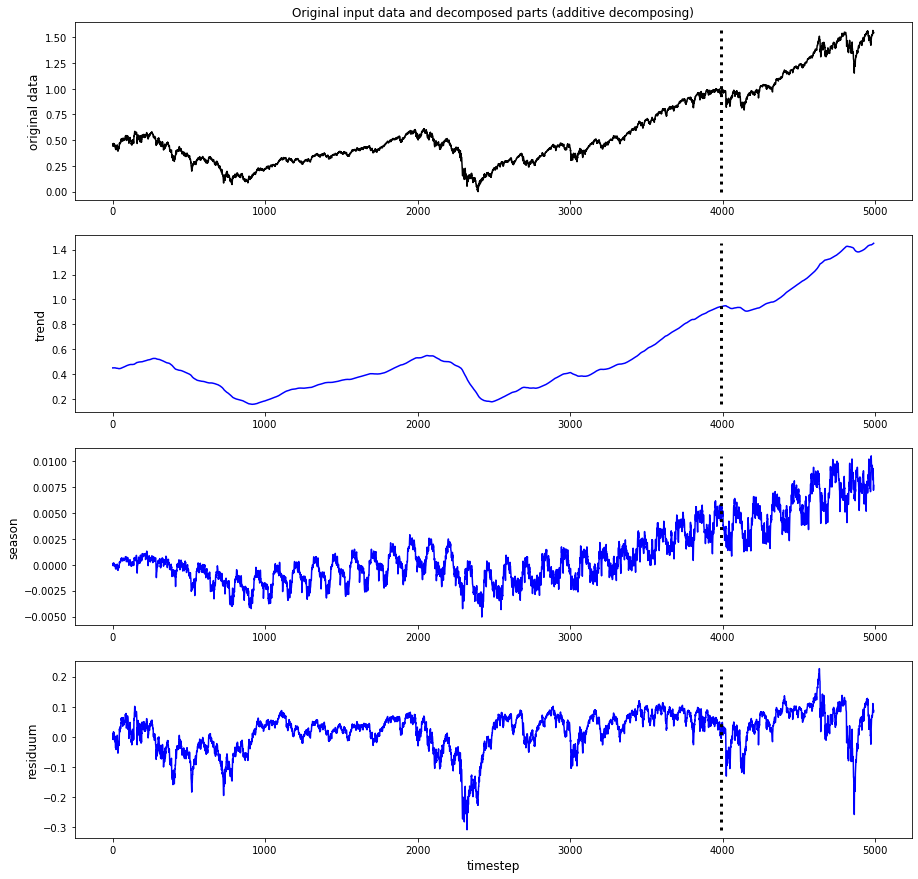


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.053152
p-value: 0.994796

Season S:
ADF Statistic: -2.991063
p-value: 0.035737

Residuum R:
ADF Statistic: -4.779381
p-value: 0.000060


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [11]:
# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)

In [12]:
### Try to model absolute SP500 stock index with base ESN: Use original series plus results from decomposition
### as input: Trend L, season S and residuum R.

## Define parameters for ESN model upfront
n_layers = 1 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 4 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

In [13]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpj51d2a7b.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpj51d2a7b.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
esn (ESN)                    ((None, 10, 100), (None,  10600     
___________________________________________________

2022-03-01 16:57:12.212301: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha


shape of train input (samples, timesteps, features):  (3992, 10, 4)


2022-03-01 16:59:36.935690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


shape of model output X_T (samples, n_res):  (3992, 100)

W_out shape:  (100, 1)
b_out shape:  (1,)

b_out before training: 
 [-0.03879869]

X_add shape:  (3992, 1)

Final reservoir states in augmented notation, shape:  (3992, 101)
train_input shape:  (3992, 10, 4)
train_target shape:  (3992, 1)
W_out_prime shape:  (101, 1)

trained b_out: 
 [-5503.99873463]

shape of val input (samples, timesteps, features):  (998, 10, 4)
shape of train input (samples, timesteps, features):  (3992, 10, 4)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_901/1319895753.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of model predictions on validation input (samples, 1):  (998, 1)
shape of val targets (samples, 1):  (998, 1)

val_mae:  0.0341
train_mae:  0.008


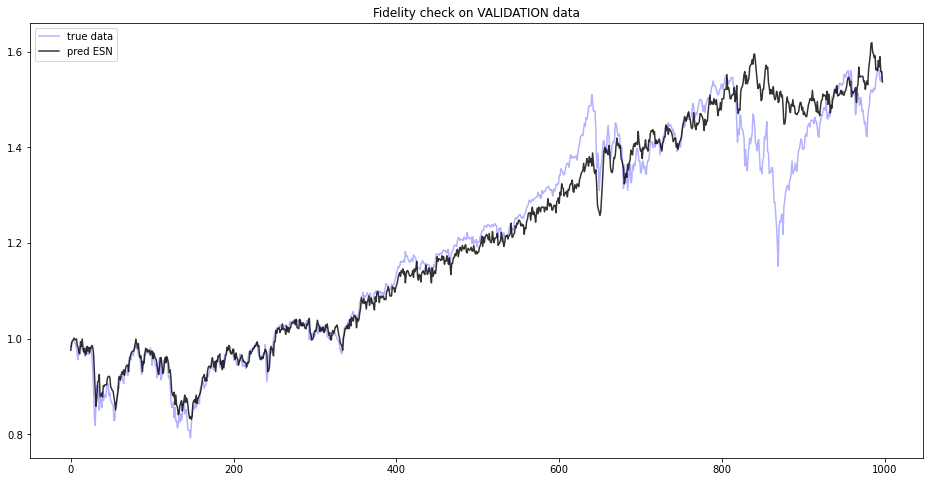

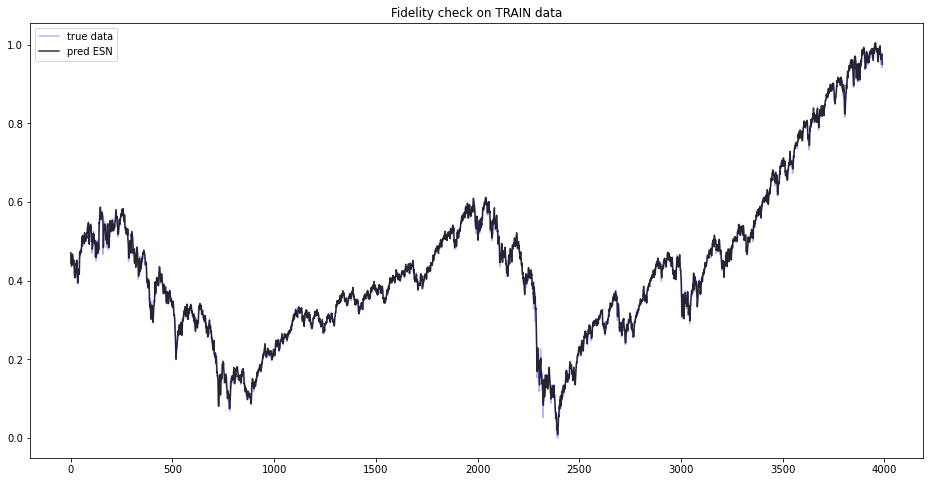

In [14]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)

# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)

# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)

# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)

# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)

## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

#### Discussion on SP500 prediction with base ESN

As expected, absolute SP500 timeseries cannot be modelled without further "external" information. Here we only used original series plus decomposed parts (trend, season, residuum) as input features. On the first glance, fidelity looks good, predictions on validation inputs seem to match validation targets.

But having a closer look at the first 50 timesteps reveals the problem: Predictions follow targets with a "lag" of exactly target length timesteps. Mulitstep prediction would fail!

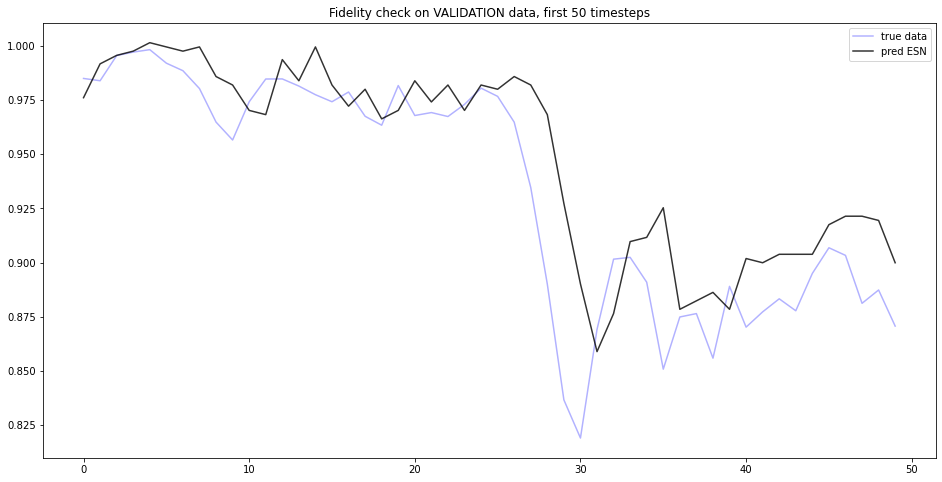

In [15]:
# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps')
plt.legend()
plt.show()

### 4a. Decomposition of airline passenger data

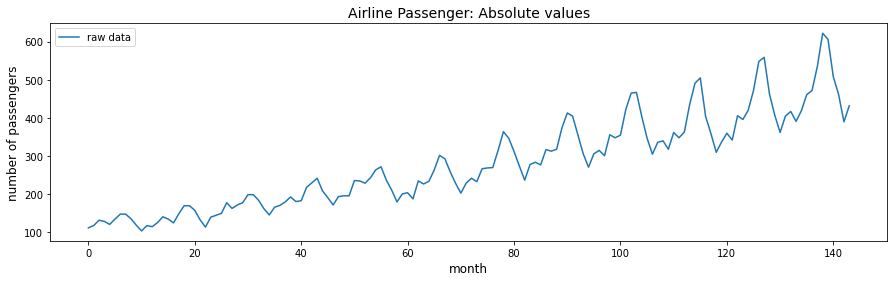

In [18]:
# First glance at raw data reveals some exponential trend and seasonality with cycle length 12 months
x_index = np.array(range(len(AirPass)))

plt.figure(figsize=(15, 4))
plt.plot(x_index, AirPass, label='raw data')
plt.title('Airline Passenger: Absolute values', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('number of passengers', fontsize=12)
plt.legend()
plt.show()

In [19]:
# Try de-trending timeseries using polynomial fit
AirPass_trend_param = np.polyfit(x_index, AirPass, 2)
AirPass_trend = (x_index**2)*AirPass_trend_param[0]+x_index*AirPass_trend_param[1]+AirPass_trend_param[2]

# Two distinct ways of de-trending: Subtract trend ("additive") vs. divide by trend ("multiplicative")
AirPass_detrend_sub = AirPass - AirPass_trend
AirPass_detrend_div = AirPass / AirPass_trend

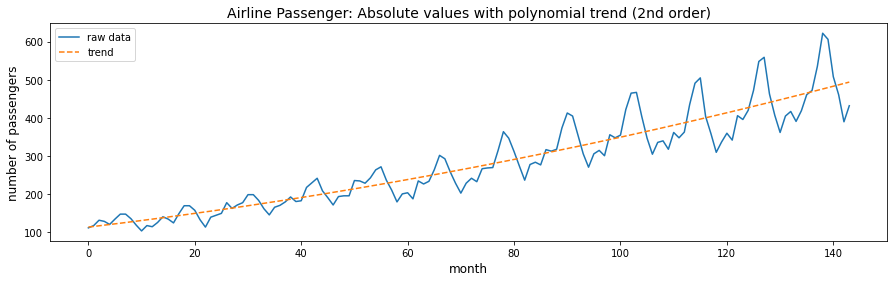

In [20]:
# Fidelity check: Plot raw data in combination with polynomial trend
plt.figure(figsize=(15, 4))
plt.plot(x_index, AirPass, label='raw data')
plt.plot(x_index, AirPass_trend, linestyle='--', label='trend')
plt.title('Airline Passenger: Absolute values with polynomial trend (2nd order)', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('number of passengers', fontsize=12)
plt.legend()
plt.show()

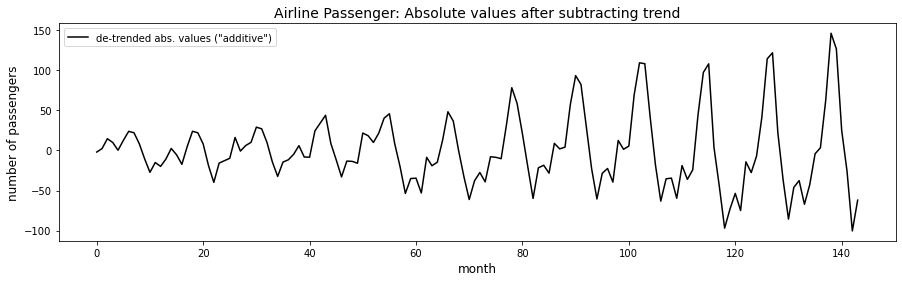

In [21]:
# Plot de-trended airline passenger number: Raw date MINUS trend
plt.figure(figsize=(15, 4))
plt.plot(x_index, AirPass_detrend_sub, color='k', label='de-trended abs. values ("additive")')
plt.title('Airline Passenger: Absolute values after subtracting trend', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('number of passengers', fontsize=12)
plt.legend()
plt.show()

In [22]:
# Find seasonality with increasing amplitude after subtracting trend.
# Try to convert de-trended absolute values to relative changes.
AirPass_detrend_rel_chg = (AirPass_detrend_sub[1:] - AirPass_detrend_sub[:-1]) / AirPass_detrend_sub[:-1]

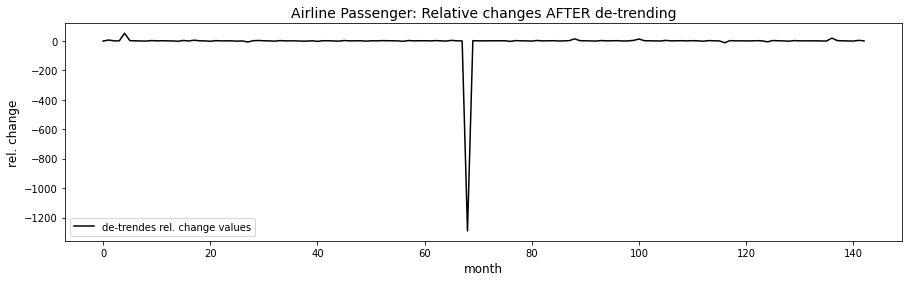

In [23]:
# Plot de-trended relative change values, where trend has been SUBTRACTED from raw absolute values before.
plt.figure(figsize=(15, 4))
plt.plot(x_index[:-1], AirPass_detrend_rel_chg, color='k', label='de-trendes rel. change values')
plt.title('Airline Passenger: Relative changes AFTER de-trending', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('rel. change', fontsize=12)
plt.legend()
plt.show()

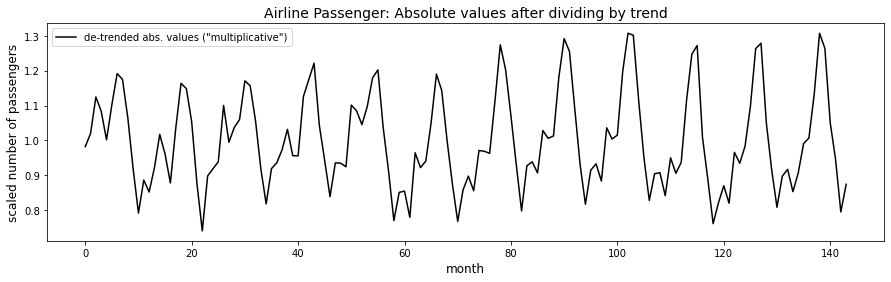

In [24]:
# Subtracting trend and subsequently converting to relative change values causes some trouble in this case:
# Having values fluctuating arround zero can lead to huge rel. changes, as observed.
# So try "multiplicative" de-trending, where we divide raw absolute values by trend:
# Plot de-trended airline passenger number: Raw date MINUS trend
plt.figure(figsize=(15, 4))
plt.plot(x_index, AirPass_detrend_div, color='k', label='de-trended abs. values ("multiplicative")')
plt.title('Airline Passenger: Absolute values after dividing by trend', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('scaled number of passengers', fontsize=12)
plt.legend()
plt.show()

In [25]:
# ADFT on AirPass_detrend_div
ADFT_AirPass_detrend_div = adfuller(AirPass_detrend_div)

# Print results from ADFT:
print('\nAirPass_detrend_div:')
print('=====================')
print('ADF Statistic: %f' % ADFT_AirPass_detrend_div[0])
print('p-value: %f' % ADFT_AirPass_detrend_div[1])


AirPass_detrend_div:
ADF Statistic: -3.313253
p-value: 0.014296


In [26]:
### Set parameters up-front for decomposing timeseries:

## Verbosity:
verbose = True

## Parameters for decomposing and splitting timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.05 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.8 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 12 # Choose cycle length for season S.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

original input series shape:  (144, 1)
train_input shape:  (107, 10, 4)
val_input shape:  (27, 10, 4)
train_target shape:  (107, 1)
val_target shape:  (27, 1)
train_min:  104
train_max:  491


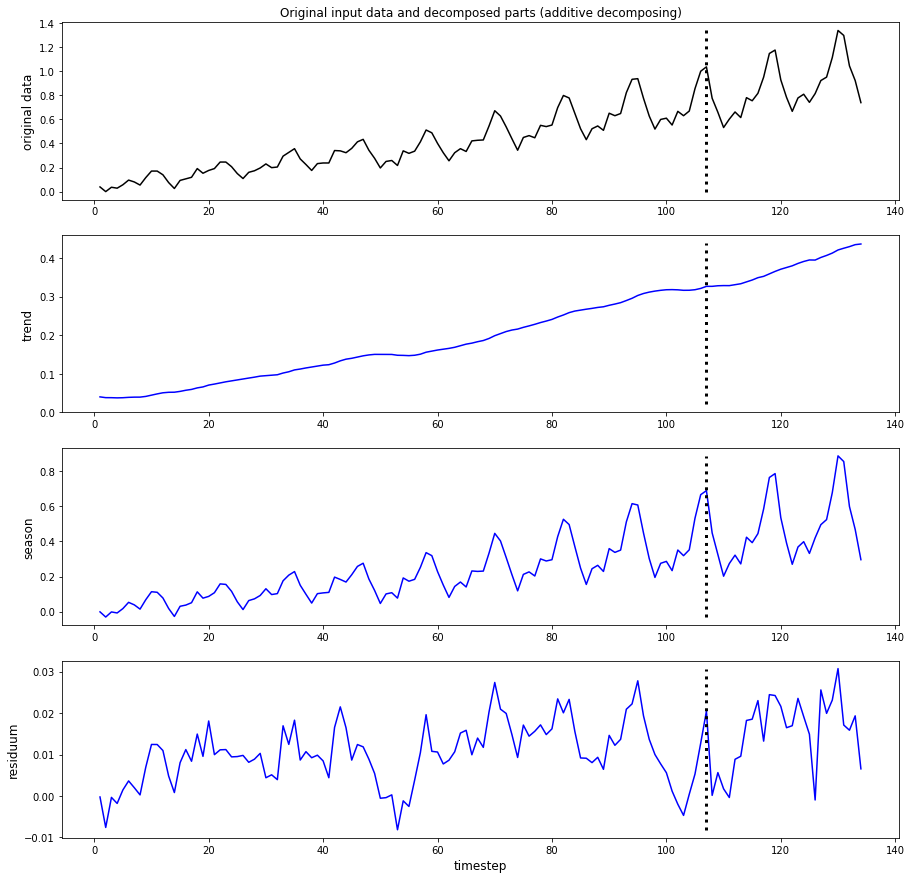


original:
ADF Statistic: 0.587400
p-value: 0.987301

Trend L:
ADF Statistic: 1.096268
p-value: 0.995185

Season S:
ADF Statistic: 0.679590
p-value: 0.989422

Residuum R:
ADF Statistic: -4.300924
p-value: 0.000443


Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


In [27]:
## Back to original absolute airline passenger series:

# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(AirPass,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)

original input series shape:  (144, 1)
train_input shape:  (107, 10, 4)
val_input shape:  (27, 10, 4)
train_target shape:  (107, 1)
val_target shape:  (27, 1)
train_min:  0.7410765465790523
train_max:  1.3070884436526304


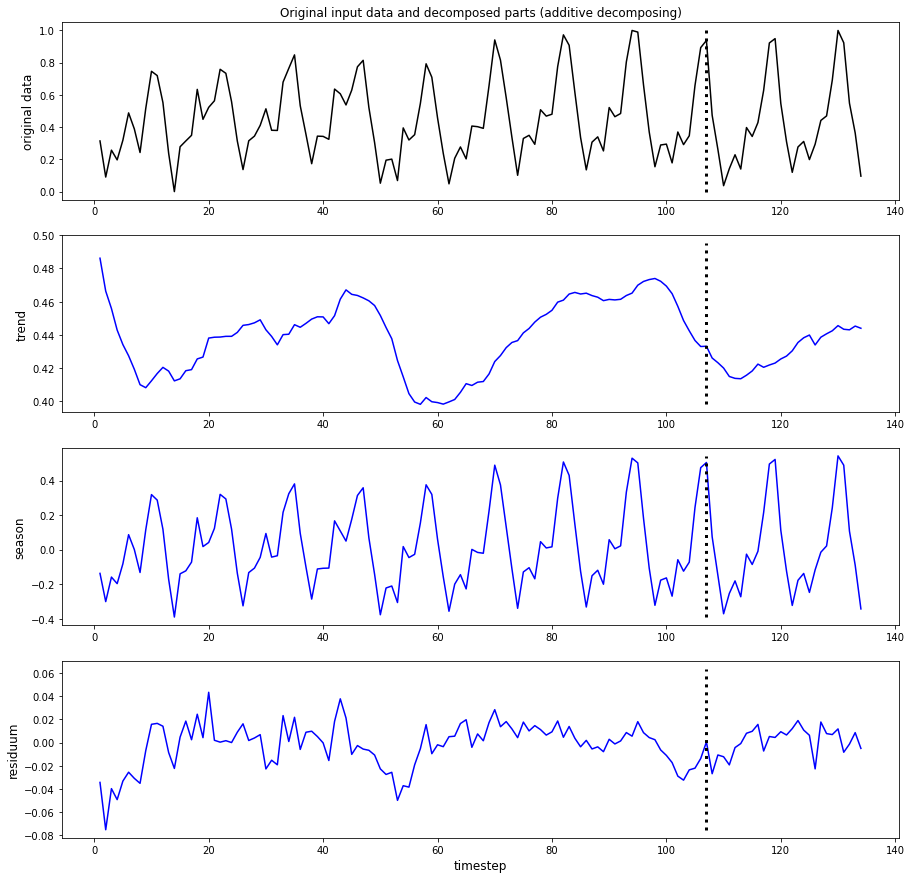


original:
ADF Statistic: -3.363925
p-value: 0.012252

Trend L:
ADF Statistic: -3.111805
p-value: 0.025692

Season S:
ADF Statistic: -3.153862
p-value: 0.022816

Residuum R:
ADF Statistic: -3.542262
p-value: 0.006966


Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579


In [28]:
## Now focus on multiplicatively de-trended airline passenger series:

# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(AirPass_detrend_div,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)

In [32]:
### Try to model multiplicatively de-trended airline passenger data, scaled to [0,1], with base ESN. 
### Only use this one series as input.

## Define parameters for ESN model upfront
n_layers = 1 # Number of ESN layers in the model.
n_res = 50 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

In [33]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
esn_1 (ESN)                  ((None, 10, 50), (None, 5 2650      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
esn_1 (ESN)                  ((None, 10, 50), (None, 5 2650      
Total params: 2,650
Trainable params: 

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


In [30]:
# Check dimensions from decomposing AirPass_detrend_div:
print("\ntrain_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)
print("val_input shape: ", val_input.shape)
print("val_target shape: ", val_target.shape)

# Want to use only first feature (= scaled original series)
train_input = train_input[:,:,0:1]
val_input = val_input[:,:,0:1]

# Check dimensions after reducing to ONE feature:
print("\ntrain_input shape: ", train_input.shape)
print("val_input shape: ", val_input.shape)


train_input shape:  (107, 10, 4)
train_target shape:  (107, 1)
val_input shape:  (27, 10, 4)
val_target shape:  (27, 1)

train_input shape:  (107, 10, 1)
val_input shape:  (27, 10, 1)



shape of train input (samples, timesteps, features):  (107, 10, 1)
shape of model output X_T (samples, n_res):  (107, 50)

W_out shape:  (50, 1)
b_out shape:  (1,)

b_out before training: 
 [0.04429812]

X_add shape:  (107, 1)

Final reservoir states in augmented notation, shape:  (107, 51)
train_input shape:  (107, 10, 1)
train_target shape:  (107, 1)
W_out_prime shape:  (51, 1)

trained b_out: 
 [496716.44147041]

shape of val input (samples, timesteps, features):  (27, 10, 1)
shape of train input (samples, timesteps, features):  (107, 10, 1)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_901/1319895753.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of model predictions on validation input (samples, 1):  (27, 1)
shape of val targets (samples, 1):  (27, 1)

val_mae:  0.1428
train_mae:  0.1204


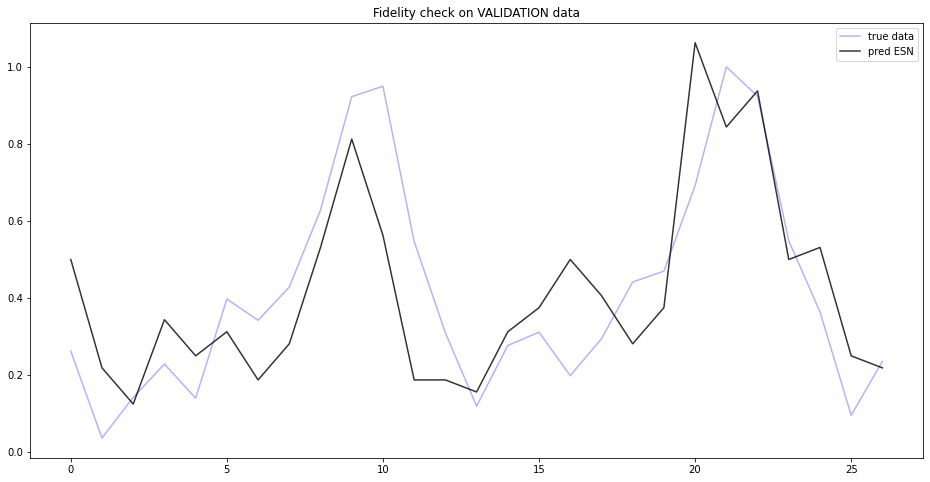

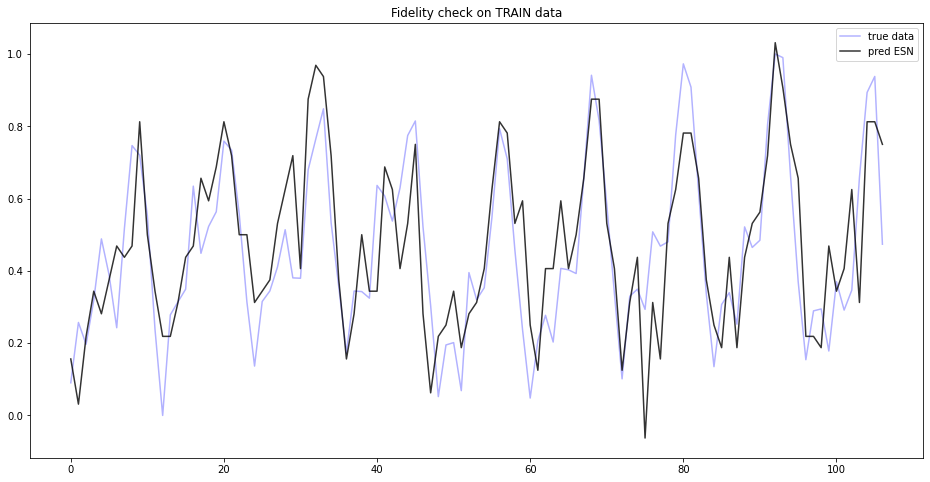

In [34]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)

# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)

# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)

# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)

# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)

## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

### 5a. Setting up (Deep)ESN models

Use leaky integrator reservoir units trained by linear regression. Leak rate $\alpha$ contains a value between 0 and 1, representing a smoothing constant. With larger value of $\alpha$ we find faster reaction to input. Then for a base ESN model with only *one* reservoir, the state of the reservoir at time $t$ is updated according to the following recurrence function:

$$x(t) = (1-\alpha)\,x(t-1)+\alpha\,act[u(t)W_{in}+\overline{b}_{in}+x(t-1)W_{res}+\overline{b}_{res}]$$

$act$ denotes the activation function, e.g. $tanh$ or $sigmoid$. $\overline{b}_{in}$ and $\overline{b}_{res}$ denote vectors of shape (samples, n_res) containing constant values $b_{in}$ and $b_{res}$ as entries, respectively.

Things slightly change for Deep ESN models with $N$ layers, hence $N$ reservoirs. The state transition function reads:

$$x^{l}(t) = (1-\alpha^{l})\,x^{l}(t-1)+\alpha^{l}\,act[i^{l}(t)W^{l}_{in}+\overline{b^{l}}_{in}+x^{l}(t-1)W^{l}_{res}+\overline{b^{l}}_{res}]$$







### 5b. Solving for output weights with linear regression, use "augmented" notation

Short model yields final reservoir states $X(T)$ with dimension (samples, n_res). 
We then have outputs weights $W_{out}$ with shape (n_res, output features) and output 
bias $b_{out}$ as single value. Train targets $Y$ have dimension (samples, output features).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Here $\overline{b}_{out}$ denotes a vector of shape (samples, output features), containing only the single output bias value $b_{out}$.

We switch to "augmented" notation and include ${b}_{out}$ as additional weight in $W_{out}$. This requires to add a column of *ones* as last column of $X(T)$, for keeping dimensions right. This leads to:

$$X'(T) \cdot W'_{out} = Y$$

where $X'(T)$ and $W'_{out}$ denote final reservoir states and output weights in augmented notation, respectively.

Solving for $W'_{out}$ we need to invert $X'(T)$, or get the pseudo-inverse $X'_{inv}$, since $X'(T)$ is usually not a square matrix:

$$W'_{out} = X'_{inv} \cdot Y$$

Doing this, we obtain trained output weights and bias. Then extract the bias (= last entry in $W'_{out}$) and plug train output weights and bias back into the model.

#### Declare global (hyper-)parameters upfront

In [110]:
## Verbosity
verbose = True

## Decomposing timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 126 # Choose cycle length for season S.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

## ESN model
n_layers = 2 # Number of ESN layers in the model.
n_res = 400 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 4 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

### ESN on decomposed absolute or rel. change values

Try different approaches for preparing input data:

- Scale raw absolute SP500 series applying min/max scaling with min/max only taken from train data, then decompose
- Alternatively scale absolute SP500 series to [0,1] with min/max taken from **whole** series, then decompose
- Alternatively convert absolute SP500 series to relative change values, then decompose *without scaling*

#### Prepare input data

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


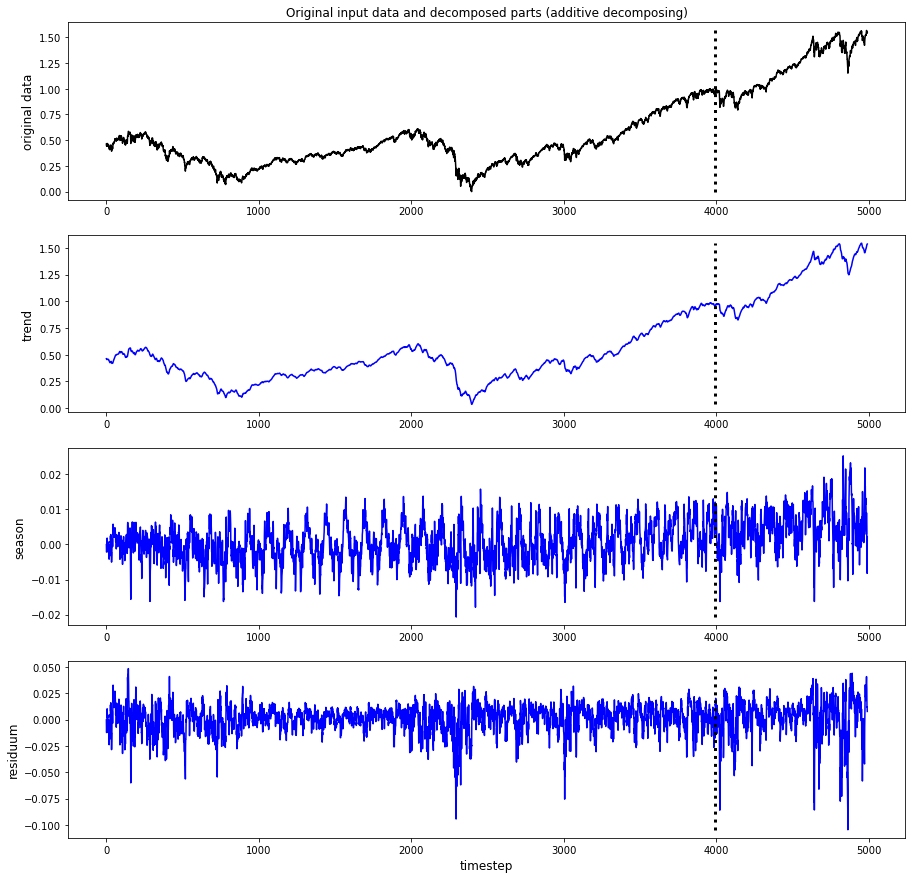


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.063965
p-value: 0.994897

Season S:
ADF Statistic: -9.959887
p-value: 0.000000

Residuum R:
ADF Statistic: -13.925091
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [6]:
# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)


min before scaling:  676.53
max before scaling:  2954.18

min after scaling:  0.0
max after scaling:  1.0 

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  0
train_max:  0


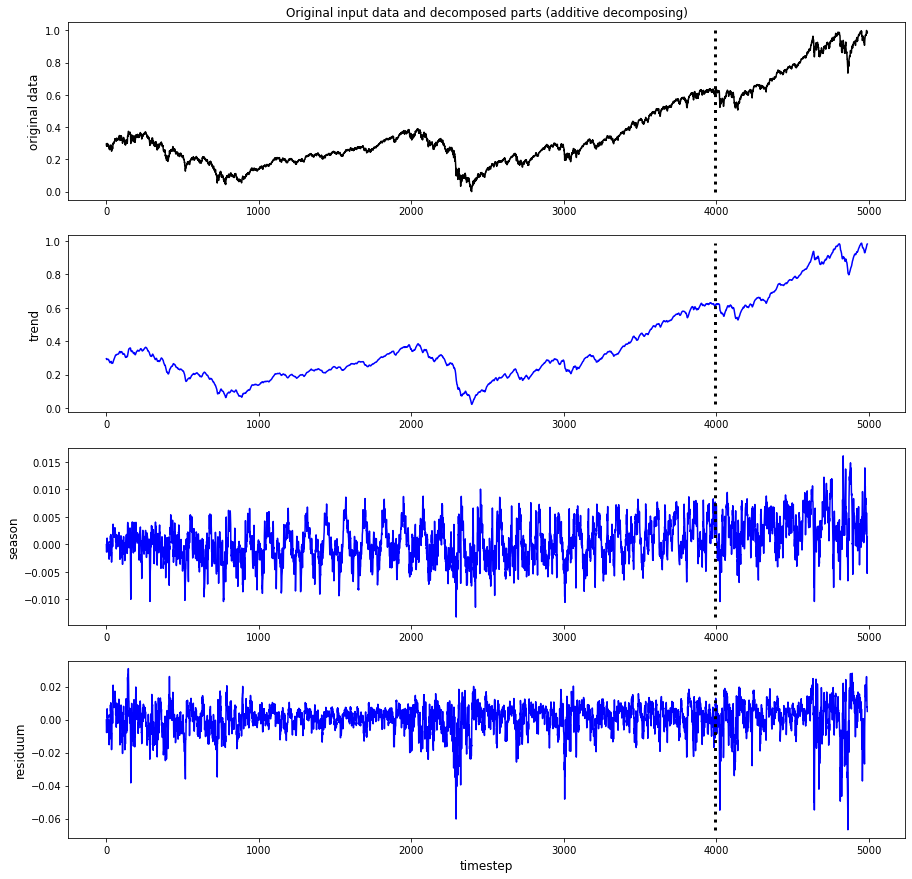


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.063965
p-value: 0.994897

Season S:
ADF Statistic: -9.959887
p-value: 0.000000

Residuum R:
ADF Statistic: -13.925091
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [27]:
### Alternatively use already scaled SP500 series:

# Manually scale absolute values to [0,1] with min/max scaling on whole series:
SP500_abs_min = np.min(SP500_abs)
SP500_abs_max = np.max(SP500_abs)
SP500_abs_scaled = (SP500_abs - SP500_abs_min) / (SP500_abs_max - SP500_abs_min)
print("\nmin before scaling: ", np.min(SP500_abs))
print("max before scaling: ", np.max(SP500_abs))
print("\nmin after scaling: ", np.min(SP500_abs_scaled))
print("max after scaling: ", np.max(SP500_abs_scaled), "\n")

# Decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs_scaled,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=False,
                                                                                         verbose=verbose)

original input series shape:  (4999, 1)
train_input shape:  (3991, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3991, 1)
val_target shape:  (998, 1)
train_min:  0
train_max:  0


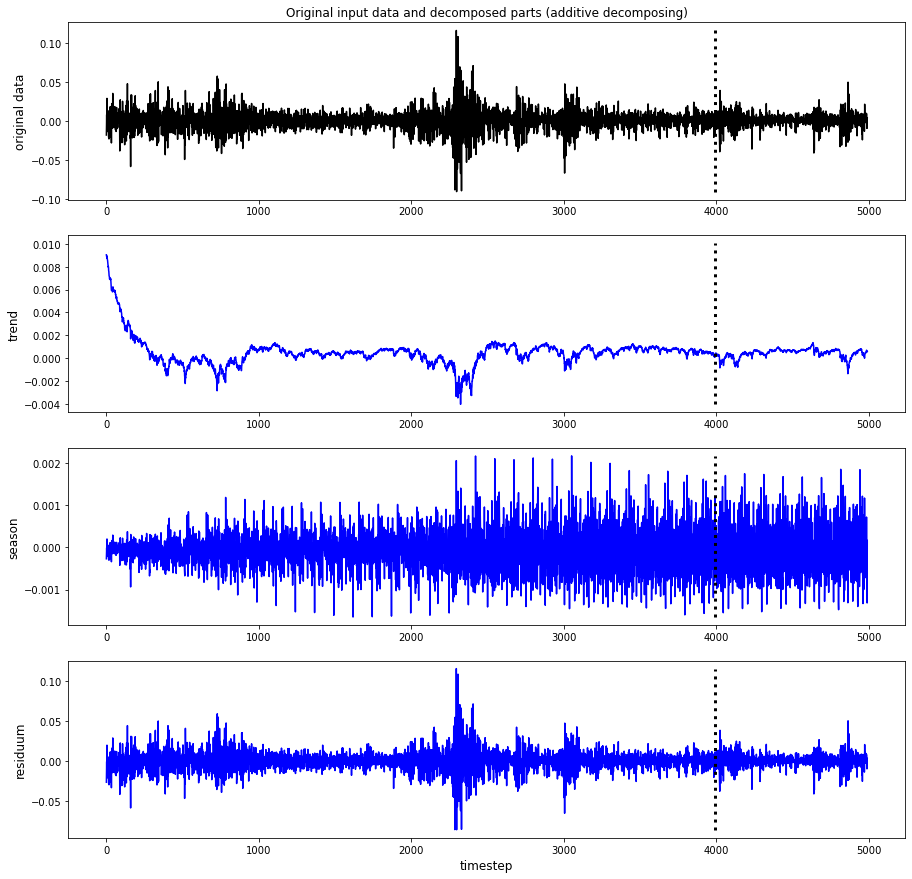


original:
ADF Statistic: -16.558156
p-value: 0.000000

Trend L:
ADF Statistic: -6.656836
p-value: 0.000000

Season S:
ADF Statistic: -12.846218
p-value: 0.000000

Residuum R:
ADF Statistic: -16.633291
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [108]:
### Alternatively convert absolute SP500 series to rel. change values before de-composing:

SP500_rel_chg = (SP500_abs[1:] - SP500_abs[:-1]) / SP500_abs[:-1]

# Decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_rel_chg,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=False,
                                                                                         verbose=verbose)

In [111]:
## Set up ESN model:

# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
esn_31 (ESN)                    ((None, 10, 400), (N 162400      input_8[0][0]                    
__________________________________________________________________________________________________
esn_32 (ESN)                    ((None, 10, 400), (N 320800      esn_31[0][0]                     
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 800)          0           esn_31[0][1]                     
                                                                 esn_32[0][1]                 

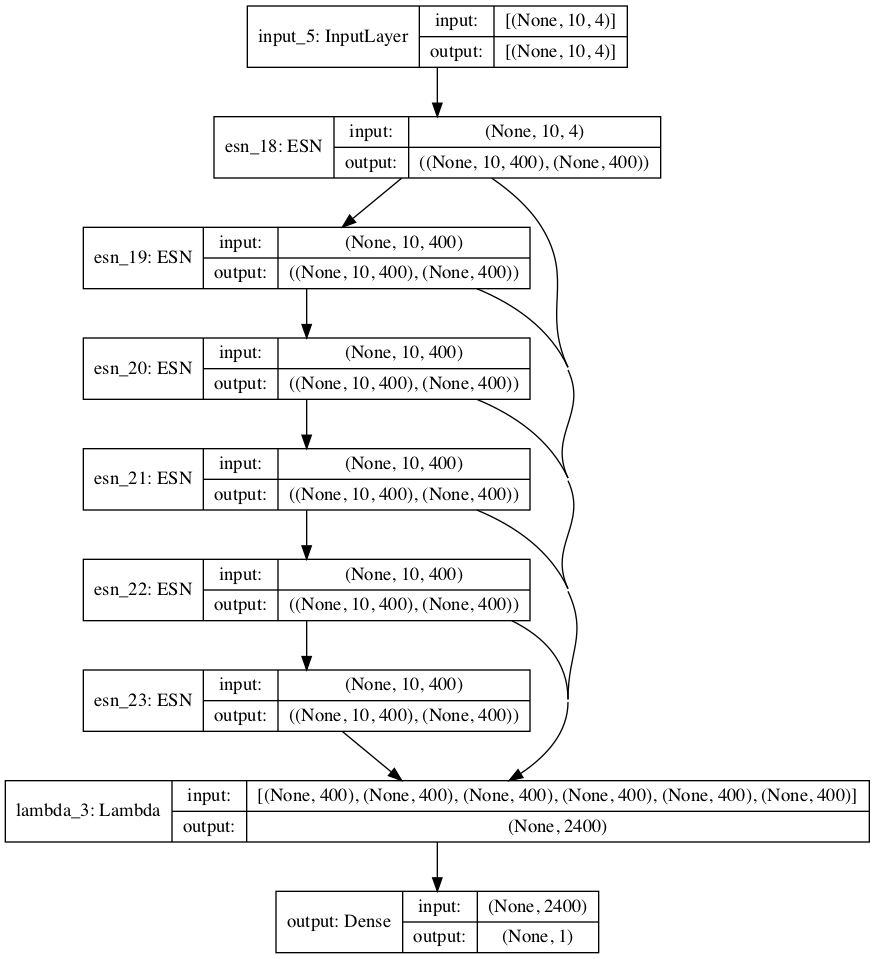

In [49]:
# Plot complete model
plot_model(model, show_shapes=True, show_layer_names=True)

### Solving for output weights with linear regression, use "augmented" notation

Short model yields final reservoir states $X(T)$ with dimension (#samples, #reservoir units). We then have outputs weights $W_{out}$ with shape (#reservoir units, 1) and output bias $b_{out}$ as single value. Train targets $Y$ have dimension (#samples, 1).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Note: Here $\overline{b}_{out}$ denotes a vector of shape (#samples, 1), containing only the single output bias value $b_{out}$.

We switch to "augmented" notation and include ${b}_{out}$ as additional weight $W_{out}$. This requires to add a column of *ones* as last column of $X(T)$, for keeping dimensions right. This leads to:

$$X'(T) \cdot W'_{out} = Y$$

where $X'(T)$ and $W'_{out}$ denote final reservoir states and output weights in augmented notation, respectively. Note: Later we might omit the primes - for convenience.

Solving for $W'_{out}$ we need to invert $X'(T)$, or get the pseudo-inverse $X'_{inv}$, since $X'(T)$ is usually not a square matrix:

$$W'_{out} = X'_{inv} \cdot Y$$

Doing this, we obtain trained output weights and bias. Then extract the bias (= last entry in $W'_{out}$) and plug train output weights and bias back into the model.

In [50]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)


shape of train input (samples, timesteps, features):  (3992, 10, 4)
shape of model output X_T (samples, n_res):  (3992, 2400)


In [112]:
# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)


W_out shape:  (800, 1)
b_out shape:  (1,)

b_out before training: 
 [-0.06502323]


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1143/981223782.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


In [115]:
for i in range(len(model_weights)):
    print("layer ",i," shape: ",model_weights[i].shape)

layer  0  shape:  (4, 400)
layer  1  shape:  (400,)
layer  2  shape:  (400, 400)
layer  3  shape:  (400,)
layer  4  shape:  (400, 400)
layer  5  shape:  (400,)
layer  6  shape:  (400, 400)
layer  7  shape:  (400,)
layer  8  shape:  (800, 1)
layer  9  shape:  (1,)


In [52]:
# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)


X_add shape:  (3992, 1)


In [53]:
# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)


Final reservoir states in augmented notation, shape:  (3992, 2401)


In [54]:
# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

train_input shape:  (3992, 10, 4)
train_target shape:  (3992, 1)
W_out_prime shape:  (2401, 1)


In [55]:
# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)


trained b_out: 
 [-712591.89681436]


In [56]:
# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)


shape of val input (samples, timesteps, features):  (998, 10, 4)
shape of train input (samples, timesteps, features):  (3992, 10, 4)

shape of model predictions on validation input (samples, 1):  (998, 1)
shape of val targets (samples, 1):  (998, 1)

val_mae:  0.1391
train_mae:  0.0668


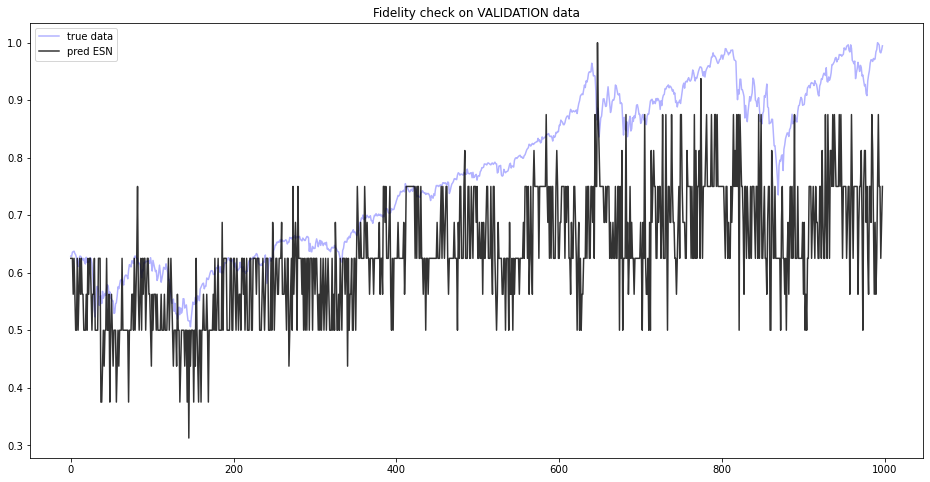

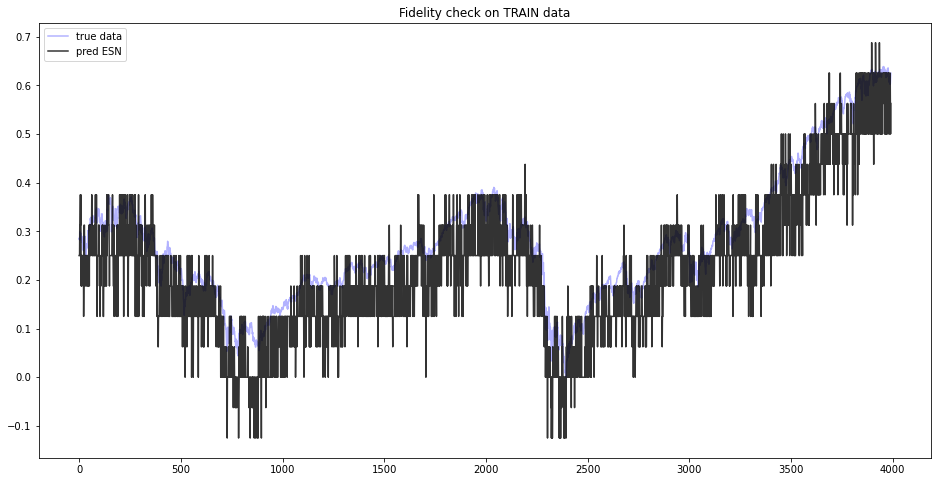

In [57]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

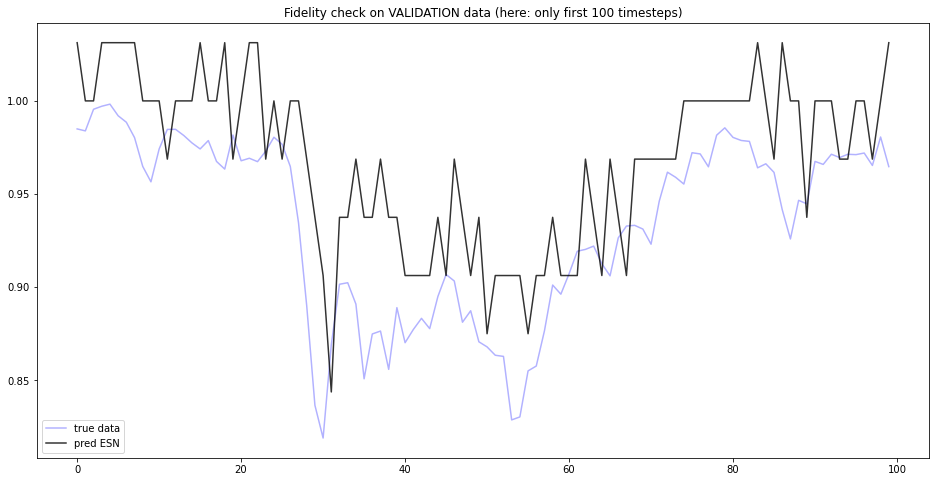

In [26]:
# Fidelity check: Plot only first 100 timesteps of val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:100])),val_target[:100],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:100])),val_pred[:100],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data (here: only first 100 timesteps)')
plt.legend()
plt.show()

### Alternative reconstruction of model predictions from absolute differences with "teacher forcing"

First attempts with ESN model on decomposed absolute stock prices failed: Predictions on validation input nicely matched validation targets, but only for the first 400 timesteps. Then we found an increasing mismatch, sometimes predictions showed a mysterious inversion in addition to that.

Try different way of reconstructing model prediction timeseries: Use absolute differences from one timestep to the next timestep and add this difference to the "true" absolute base value ("teacher forcing").

Check fidelity with this approach.

In [39]:
# Initialize storage for time series reconstructed from absolute differences of validation predictions:
val_pred_from_abs_diff = np.zeros((len(val_target), 1))

# Get absolute differences from model predictions on validation data:
val_pred_abs_diff = val_pred[1:] - val_pred[:-1]


(997, 1)

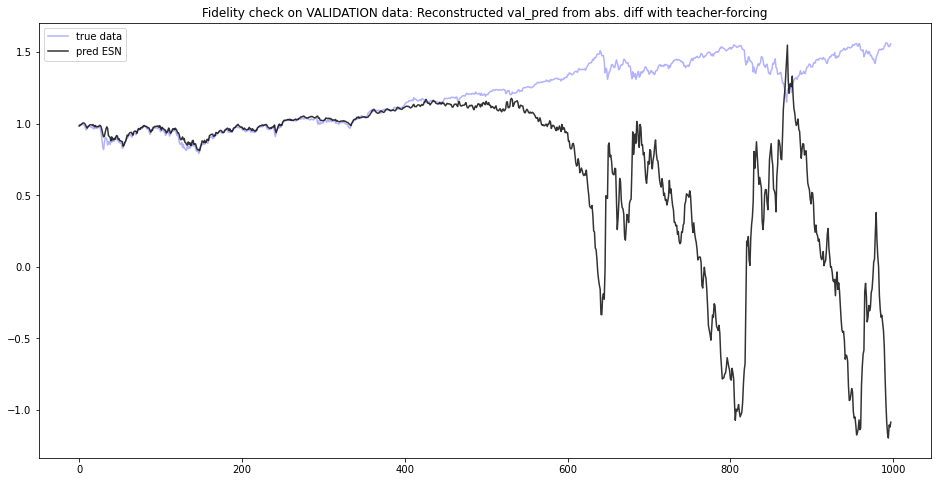

In [41]:
# Initialize storage for time series reconstructed from absolute differences of validation predictions:
val_pred_from_abs_diff = np.zeros(len(val_target))

# Hook on true base value:
val_pred_from_abs_diff[0] = val_target[0,0]

# Get absolute differences from model predictions on validation data:
val_pred_abs_diff = val_pred[1:,0] - val_pred[:-1,0]
                                  
                                  
# Loop over series of absolute differences, remember: Hook on true base value
for i in range(len(val_pred_abs_diff)):

    val_pred_from_abs_diff[i+1] = val_pred_from_abs_diff[i] + val_pred_abs_diff[i]

# Re-shape to have same dimensions as target (samples, 1)
val_pred_from_abs_diff = np.reshape(val_pred_from_abs_diff, (len(val_pred_from_abs_diff), 1))
    
# Fidelity check: Plot val_pred_from_abs_diff vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_from_abs_diff)),val_pred_from_abs_diff,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data: Reconstructed val_pred from abs. diff with teacher-forcing')
plt.legend()
plt.show()

#### Discussion on alternative approach of reconstructing val_pred from absolute differences, hooked on true base values

The fidelity is still lousy. The problem could be the scaling of absolute input values: We used min/max scaling with min/max obtained from train data. Since we find a rather straight up-trend in stock data, this leads to validation inputs significantly exceeding upper scaling range (=1) after some 400 timesteps.

--> Try to scale inputs differently to have all inputs - train and validation - safely within range [0,1] OR adjust hyper-parameters, e.g. spectral radius and/or leak rate.

### ESN on relative change values

First attempts with ESN model on decomposed absolute stock prices failed: Predictions on validation input nicely matched validation targets, but only for the first 400 timesteps. Then we found an increasing mismatch, sometimes predictions showed a mysterious inversion in addition to that.

Decided to step back and work with only one input feature, hence no decomposing. And switch to working with relative change values.

Then try to find a combination of (hyper-)parameters that produce stable and reproducible predictions on validation data, before increasing number of layers.

#### Declare global (hyper-)parameters upfront

In [67]:
## Verbosity
verbose = True

## Decomposing timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 126 # Choose cycle length for season S.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

## ESN model
n_layers = 1 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.5 # Leak rate used in transition function of reservoir states.
spec_radius = 1.0 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

#### Prepare input data

In [68]:
# Split input timeseries (absolute data) and convert to relative change values.
train_input, val_input, train_target, val_target, train_min, train_max = split_data(SP500_abs,
                                                                                    input_length=input_length,
                                                                                    target_length=target_length,
                                                                                    train_val_split=train_val_split,
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

raw data shape:  (4999,)
train_input shape:  (3991, 10, 1)
val_input shape:  (998, 10, 1)
train_target shape:  (3991, 1)
val_target shape:  (998, 1)
train_min:  0
train_max:  0


In [5]:
## Set up ESN model:

# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphcq9y41t.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphcq9y41t.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
esn (ESN)                    ((None, 10, 100), (None,  10300     
___________________________________________________

2022-02-25 13:35:55.807599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:651: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:690: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

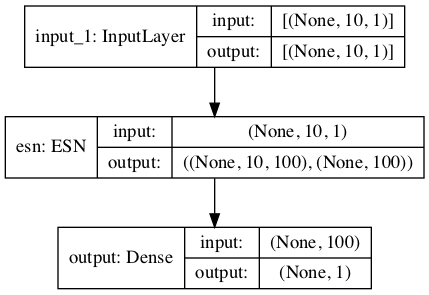

In [6]:
# Plot complete model
plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)


shape of train input (samples, timesteps, features):  (3991, 10, 1)


2022-02-25 13:36:04.128558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


shape of model output X_T (samples, n_res):  (3991, 100)


In [8]:
# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)


W_out shape:  (100, 1)
b_out shape:  (1,)

b_out before training: 
 [-0.10400391]


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1171/981223782.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


In [9]:
# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)


X_add shape:  (3991, 1)


In [10]:
# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)


Final reservoir states in augmented notation, shape:  (3991, 101)


In [11]:
# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

train_input shape:  (3991, 10, 1)
train_target shape:  (3991, 1)
W_out_prime shape:  (101, 1)


In [13]:
# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1,:]

#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)


trained b_out: 
 [-14200.77893968]


In [14]:
# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)


shape of val input (samples, timesteps, features):  (998, 10, 4)
shape of train input (samples, timesteps, features):  (3991, 10, 4)

shape of model predictions on validation input (samples, 1):  (998, 1)
shape of val targets (samples, 1):  (998, 1)

val_mae:  0.0061
train_mae:  0.0083


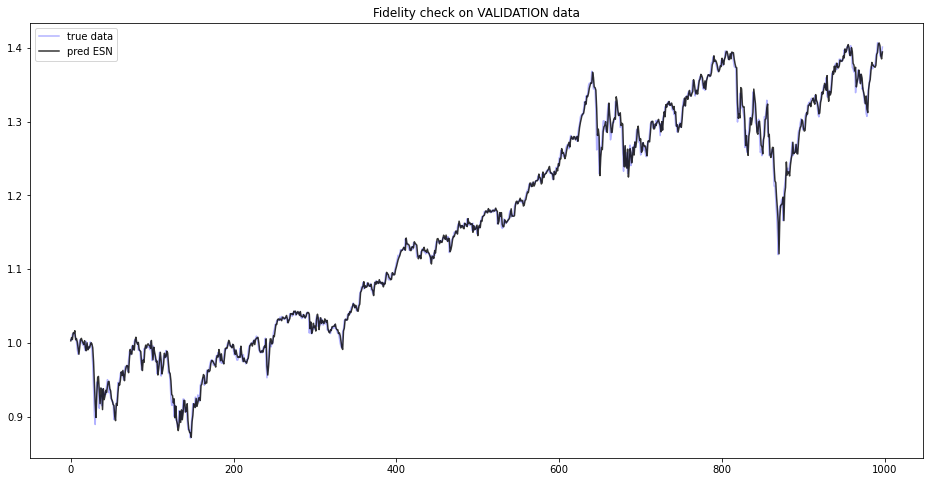

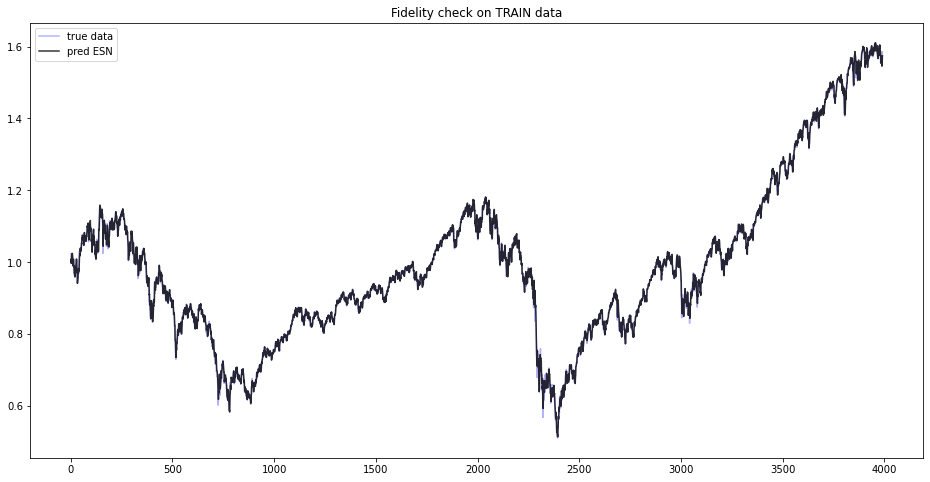

In [119]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

val_target_abs, val_pred_abs = rel_to_abs(val_target, val_pred, target_length=target_length,
                                          abs_base=1.0, verbose=False)
train_target_abs, train_pred_abs = rel_to_abs(train_target, train_pred, target_length=target_length,
                                          abs_base=1.0, verbose=False)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_abs)),val_target_abs,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_abs)),val_pred_abs,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target_abs)),train_target_abs,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred_abs)),train_pred_abs,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

In [120]:
# Get precidtion accuracy (in terms of correctly predicted up/down movements) on validation and train data:
print("val accuracy: ", np.round(np.sum((val_target[:,0] > 0) == (val_pred[:,0] > 0)) / len(val_target),2))
print("train accuracy: ", np.round(np.sum((train_target[:,0] > 0) == (train_pred[:,0] > 0)) / len(train_target),2))

val accuracy:  0.5
train accuracy:  0.53
